<a href="https://colab.research.google.com/github/JairoMillapan/Tarea_2_IA/blob/main/2023_2_UOH_COM4402_Tarea_2_JairoMillapan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Jairo Millapán

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [22]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Subir datasets de dígitos (train)

In [23]:
!wget https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_train.txt

--2023-10-30 03:51:57--  https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_train.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_train.txt [following]
--2023-10-30 03:51:57--  https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.1’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.03s   

2023-10-30 03:51:58 (19.2 MB/s) - ‘1_digits_train.txt.1’ saved [640604/640604]



In [24]:
!wget https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_test.txt

--2023-10-30 03:51:58--  https://github.com/JairoMillapan/Tarea_2_IA/raw/main/1_digits_test.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_test.txt [following]
--2023-10-30 03:51:58--  https://raw.githubusercontent.com/JairoMillapan/Tarea_2_IA/main/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt.1’

1_digits_test.txt.1 100%[===================>] 183.20K  --.-KB/s    in 0.02s   

2023-10-30 03:51:58 (7.86 MB/s) - ‘1_digits_test.txt.1’ saved [187595/187595]



## Leer dataset de dígitos

In [25]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [26]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [27]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [28]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [29]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-29-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-29-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-29-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

In [30]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [31]:
model = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [32]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Crear datasets y dataloaders para pytorch (train)

In [33]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [34]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [35]:
batch_size = 128
patience = 10
max_epochs = 1000

#Función para cargar datos y crear dataloaders
def create_dataloader(df, batch_size=128):
    feats = df.iloc[:, :64].to_numpy().astype(np.float32)
    labels = df.iloc[:, 64].astype(int)
    dataset = [{"features": feats[i, :], "labels": labels.iloc[i]} for i in range(len(feats))]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader

#Función para entrenar y evaluar el modelo
def train_and_evaluate(model, dataloader_train, dataloader_val, patience=10, max_epochs=1000): #Como parámetros recibe el modelo de la red neuronal, los dataloaders de entrenamiento y validación
#el parámetro patience para evitar el overfitting y el número de épocas
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu
    model = model.to(device) #Movemos el modelo para ejecutarlo en gpu

    criterion = nn.CrossEntropyLoss() #Línea que permite controlar la pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Línea que permite optimizar el funcionamiento del código

    best_validation_loss = float('inf') #Registra el mejor valor de pérdida de validación
    epochs_without_improvement = 0 #Cuenta las cantidades de épocas sin mejora

    loss_train = [] #Arreglo para guardar la pérdida del entrenamiento
    loss_val = [] #Arreglo para guardar la pérdida de validación
    epochs = [] #Arreglo que guarda las épocas

    start = time.time() #Comenzamos el contador para saber cuánto demora el entrenamiento

    for epoch in range(max_epochs): #Creamos un ciclo, que se repetirá hasta las 1000 épocas
        loss_train_batches = [] #Arreglo para guardar las pérdidas de entrenamiento
        loss_val_batches = [] #Arreglo para guardar las pérdidas de validación

        model.train() #Con esta línea, nuestro modelo de red neuronal está en modo entrenamiento

        for i, data in enumerate(dataloader_train, 0): #En este recorremos los datos de entrenamiento,
        #se mueven los datos y etiquetas, se calcula la pérdida, se realiza la retropropagación y se actualizan los pesos del modelo.
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches)) #Guardamos los valores de pérdida de entrenamiento de cada época

        model.eval() #Colocamos el modelo en modo evaluación

        with torch.no_grad():
            for i, data in enumerate(dataloader_val, 0): #En este bucle recorremos los datos de validación y se calcula la pérdida de validación.
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_val_batches.append(loss.item())

        loss_val.append(np.mean(loss_val_batches)) #Guardamos los valores de pérdida de validación de cada época
        epochs.append(epoch) #Guardamos las épocas ejecutadas

        print("Epoch: %d, train loss: %.4f, val loss: %.4f" % (epoch, loss_train[epoch], loss_val[epoch])) #Imprimimos el número de cada época, la pérdida de entrenamiento de esa época y la pérdida de
        #validación de esa época

        #Condicionales creadas con el fin de evitar el overfitting, las condiciones son, si no hay mejora en la pérdida de validación se deja de ejecutar el código
        if loss_val[epoch] < best_validation_loss: #si es menor la pérdida de validación a la mejor pérdida de validación
            best_validation_loss = loss_val[epoch] #se convertirá en la nueva mejor pérdida
            torch.save(model.state_dict(), 'best_model_checkpoint.pth') #guardamos
            epochs_without_improvement = 0 #no hay épocas sin mejora
        else:
            epochs_without_improvement += 1 #sino, agregamos 1

        if epochs_without_improvement >= patience: #cuando las épocas sin mejora superan a 10
            break #termina de ejecutarse el entrenamiento

    end = time.time() #terminamos el tiempo
    print('Finished Training, total time %f seconds' % (end - start)) #imprimimos el tiempo final de ejecución

    return loss_train, loss_val, epochs #retornamos

#Función para visualizar la pérdida
def plot_loss(epochs, loss_train, loss_val): #parámetros a  graficar
    plt.figure(figsize=(8, 5))
    plt.title('Loss train and val') #título del gráfico
    plt.xlabel('Epochs') #título del eje x
    plt.ylabel('Loss') #título del eje y
    plt.plot(epochs, loss_train, 'b', label='Train') #graficamos la curva de pérdida de entrenamiento
    plt.plot(epochs, loss_val, 'r', label='Val') #graficamos la curva de pérdida de validación
    plt.grid() #agregamos cuadrícula
    plt.legend() #agregamos leyenda para cada curva
    plt.show() #mostramos el gráfico

#Función para calcular y mostrar la matriz de confusión y la precisión normalizada
def evaluate_model(model, dataloader):
    model.eval() #ponemos el modelo en modo evaluación
    all_predictions = [] #arreglo para guardar las predicciones
    all_labels = [] #arreglo para guardar las etiquetas

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu

    for i, data in enumerate(dataloader, 0): #bucle para calcular las predicciones con sus respectivas etiquetas
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true') #generamos la matriz de confusión
    accuracy = accuracy_score(all_labels, all_predictions) #generamos la precisión

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels)) #mostramos la matriz
    disp = disp.plot(cmap="Blues", values_format='.2f') #mostramos la matriz

    print("Accuracy: ", accuracy) #imprimimos la precisión

# **Llamaremos a las funciones principales en las siguientes celdas, con los parámetros solicitados en cada punto**

# **(a) 10 neuronas en 1 capa oculta, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2384, val loss: 2.1480
Epoch: 1, train loss: 2.0537, val loss: 1.9523
Epoch: 2, train loss: 1.8572, val loss: 1.7466
Epoch: 3, train loss: 1.6453, val loss: 1.5217
Epoch: 4, train loss: 1.4294, val loss: 1.3137
Epoch: 5, train loss: 1.2295, val loss: 1.1298
Epoch: 6, train loss: 1.0547, val loss: 0.9987
Epoch: 7, train loss: 0.9075, val loss: 0.8498
Epoch: 8, train loss: 0.7907, val loss: 0.7396
Epoch: 9, train loss: 0.6952, val loss: 0.6602
Epoch: 10, train loss: 0.6156, val loss: 0.5993
Epoch: 11, train loss: 0.5523, val loss: 0.5373
Epoch: 12, train loss: 0.4972, val loss: 0.4940
Epoch: 13, train loss: 0.4517, val loss: 0.4493
Epoch: 14, train loss: 0.4148, val loss: 0.4087
Epoch: 15, train loss: 0.3806, val loss: 0.3933
Epoch: 16, train loss: 0.3544, val loss: 0.3539
Epoch: 17, train loss: 0.3302, val loss: 0.3502
Epoch: 18, train loss: 0.3090, val loss: 0.3173
Epoch: 19, train loss: 0.2903, val loss: 0.3310
Epoch: 20, train loss: 0.2756, val loss: 0.2884
Ep

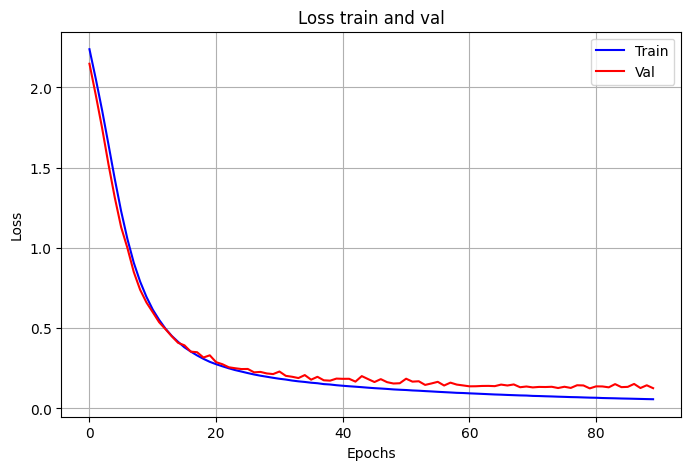

Accuracy:  0.9624521072796934
confusion:  [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.94354839 0.         0.         0.         0.
  0.00806452 0.         0.03225806 0.01612903]
 [0.         0.00694444 0.97916667 0.         0.01388889 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.99236641 0.         0.
  0.         0.         0.00763359 0.        ]
 [0.         0.00769231 0.         0.         0.94615385 0.
  0.00769231 0.         0.00769231 0.03076923]
 [0.         0.         0.         0.01503759 0.         0.92481203
  0.0075188  0.         0.0075188  0.04511278]
 [0.00793651 0.         0.         0.         0.         0.
  0.99206349 0.         0.         0.        ]
 [0.         0.         0.         0.         0.01388889 0.00694444
  0.         0.97222222 0.00694444 0.        ]
 [0.00854701 0.02564103 0.         0.         0.         0.00854701
  0.00854701 0.   

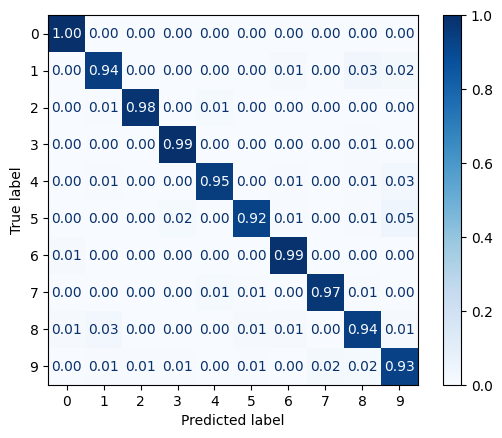

In [36]:
model1 = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
dataloader_train1 = create_dataloader(df_train, batch_size)
dataloader_val1 = create_dataloader(df_val, batch_size)
loss_train1, loss_val1, epochs1 = train_and_evaluate(model1, dataloader_train1, dataloader_val1, patience, max_epochs)
plot_loss(epochs1, loss_train1, loss_val1)
evaluate_model(model1, dataloader_val1)

# **(b) 40 neuronas en 1 capa oculta, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.1753, val loss: 1.9739
Epoch: 1, train loss: 1.7650, val loss: 1.5359
Epoch: 2, train loss: 1.3085, val loss: 1.0666
Epoch: 3, train loss: 0.8944, val loss: 0.7309
Epoch: 4, train loss: 0.6146, val loss: 0.5271
Epoch: 5, train loss: 0.4498, val loss: 0.3943
Epoch: 6, train loss: 0.3528, val loss: 0.3111
Epoch: 7, train loss: 0.2910, val loss: 0.2729
Epoch: 8, train loss: 0.2488, val loss: 0.2388
Epoch: 9, train loss: 0.2178, val loss: 0.2146
Epoch: 10, train loss: 0.1945, val loss: 0.1908
Epoch: 11, train loss: 0.1759, val loss: 0.1777
Epoch: 12, train loss: 0.1599, val loss: 0.1755
Epoch: 13, train loss: 0.1467, val loss: 0.1696
Epoch: 14, train loss: 0.1359, val loss: 0.1575
Epoch: 15, train loss: 0.1258, val loss: 0.1409
Epoch: 16, train loss: 0.1179, val loss: 0.1346
Epoch: 17, train loss: 0.1094, val loss: 0.1239
Epoch: 18, train loss: 0.1033, val loss: 0.1191
Epoch: 19, train loss: 0.0975, val loss: 0.1216
Epoch: 20, train loss: 0.0916, val loss: 0.1204
Ep

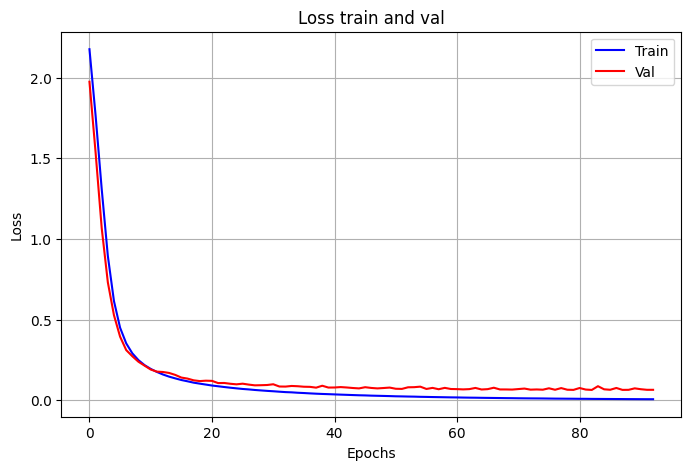

Accuracy:  0.9800766283524904
confusion:  [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.97580645 0.         0.         0.         0.
  0.         0.         0.02419355 0.        ]
 [0.         0.00694444 0.98611111 0.         0.         0.00694444
  0.         0.         0.         0.        ]
 [0.         0.         0.00763359 0.99236641 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00769231 0.         0.         0.97692308 0.
  0.         0.         0.         0.01538462]
 [0.         0.         0.         0.0075188  0.         0.96240602
  0.         0.         0.         0.03007519]
 [0.         0.         0.         0.         0.01587302 0.
  0.98412698 0.         0.         0.        ]
 [0.         0.         0.         0.         0.00694444 0.
  0.         0.99305556 0.         0.        ]
 [0.         0.00854701 0.         0.         0.00854701 0.00854701
  0.         0.   

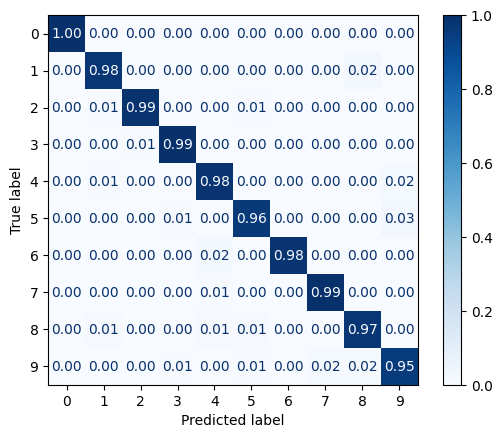

In [37]:
model2 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train2 = create_dataloader(df_train, batch_size)
dataloader_val2 = create_dataloader(df_val, batch_size)
loss_train2, loss_val2, epochs2 = train_and_evaluate(model2, dataloader_train2, dataloader_val2, patience, max_epochs)
plot_loss(epochs2, loss_train2, loss_val2)
evaluate_model(model2, dataloader_val2)

# **(c) 10 neuronas en 1 capa oculta, Tanh, 1000 épocas**

Epoch: 0, train loss: 2.2164, val loss: 2.0806
Epoch: 1, train loss: 1.9758, val loss: 1.8625
Epoch: 2, train loss: 1.7792, val loss: 1.6829
Epoch: 3, train loss: 1.6084, val loss: 1.5203
Epoch: 4, train loss: 1.4531, val loss: 1.3664
Epoch: 5, train loss: 1.3147, val loss: 1.2398
Epoch: 6, train loss: 1.1900, val loss: 1.1233
Epoch: 7, train loss: 1.0806, val loss: 1.0181
Epoch: 8, train loss: 0.9820, val loss: 0.9311
Epoch: 9, train loss: 0.8960, val loss: 0.8432
Epoch: 10, train loss: 0.8208, val loss: 0.7778
Epoch: 11, train loss: 0.7548, val loss: 0.7368
Epoch: 12, train loss: 0.6969, val loss: 0.6672
Epoch: 13, train loss: 0.6456, val loss: 0.6143
Epoch: 14, train loss: 0.6000, val loss: 0.5775
Epoch: 15, train loss: 0.5606, val loss: 0.5450
Epoch: 16, train loss: 0.5265, val loss: 0.5101
Epoch: 17, train loss: 0.4949, val loss: 0.4890
Epoch: 18, train loss: 0.4662, val loss: 0.4655
Epoch: 19, train loss: 0.4411, val loss: 0.4367
Epoch: 20, train loss: 0.4177, val loss: 0.4157
Ep

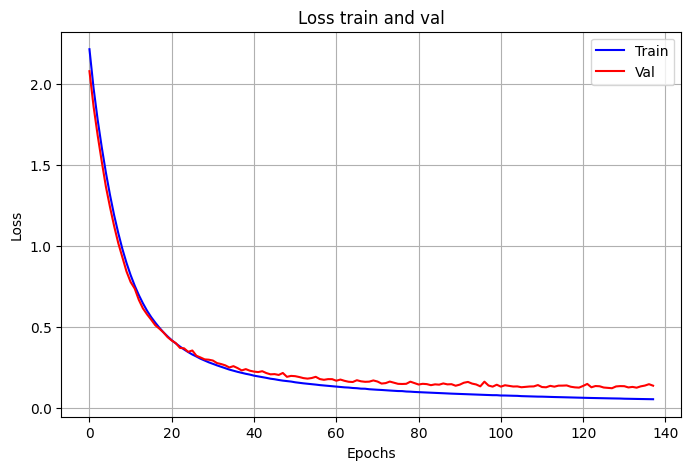

Accuracy:  0.957088122605364
confusion:  [[0.99212598 0.         0.         0.         0.00787402 0.
  0.         0.         0.         0.        ]
 [0.         0.9516129  0.         0.         0.00806452 0.
  0.01612903 0.         0.01612903 0.00806452]
 [0.         0.01388889 0.96527778 0.         0.01388889 0.
  0.         0.         0.00694444 0.        ]
 [0.         0.         0.00763359 0.97709924 0.         0.
  0.         0.         0.00763359 0.00763359]
 [0.         0.01538462 0.         0.         0.93846154 0.
  0.         0.         0.02307692 0.02307692]
 [0.01503759 0.         0.         0.0075188  0.         0.93984962
  0.         0.         0.         0.03759398]
 [0.00793651 0.         0.         0.         0.         0.00793651
  0.98412698 0.         0.         0.        ]
 [0.         0.         0.         0.00694444 0.01388889 0.
  0.         0.97222222 0.         0.00694444]
 [0.01709402 0.02564103 0.         0.         0.00854701 0.00854701
  0.         0.    

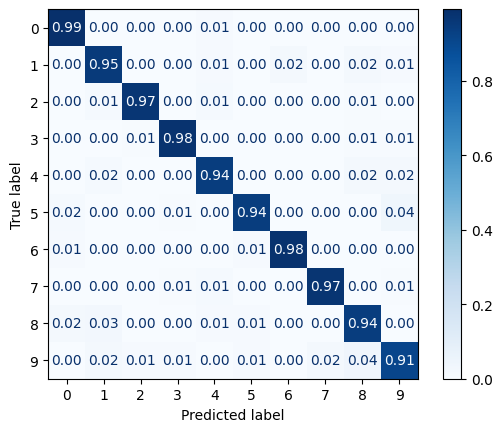

In [39]:
model3 = nn.Sequential(
    nn.Linear(64, 10),
    nn.Tanh(),
    nn.Linear(10, 10)
)
dataloader_train3 = create_dataloader(df_train, batch_size)
dataloader_val3 = create_dataloader(df_val, batch_size)
loss_train3, loss_val3, epochs3 = train_and_evaluate(model3, dataloader_train3, dataloader_val3, patience, max_epochs)
plot_loss(epochs3, loss_train3, loss_val3)
evaluate_model(model3, dataloader_val3)

# **(d) 40 neuronas usando Tanh, 1000 épocas**

Epoch: 0, train loss: 2.0539, val loss: 1.7698
Epoch: 1, train loss: 1.5300, val loss: 1.3095
Epoch: 2, train loss: 1.1268, val loss: 0.9535
Epoch: 3, train loss: 0.8376, val loss: 0.7273
Epoch: 4, train loss: 0.6423, val loss: 0.5532
Epoch: 5, train loss: 0.5090, val loss: 0.4573
Epoch: 6, train loss: 0.4174, val loss: 0.3748
Epoch: 7, train loss: 0.3523, val loss: 0.3410
Epoch: 8, train loss: 0.3050, val loss: 0.2903
Epoch: 9, train loss: 0.2682, val loss: 0.2592
Epoch: 10, train loss: 0.2397, val loss: 0.2477
Epoch: 11, train loss: 0.2181, val loss: 0.2138
Epoch: 12, train loss: 0.1986, val loss: 0.1985
Epoch: 13, train loss: 0.1830, val loss: 0.1927
Epoch: 14, train loss: 0.1693, val loss: 0.1721
Epoch: 15, train loss: 0.1580, val loss: 0.1712
Epoch: 16, train loss: 0.1485, val loss: 0.1611
Epoch: 17, train loss: 0.1400, val loss: 0.1556
Epoch: 18, train loss: 0.1318, val loss: 0.1572
Epoch: 19, train loss: 0.1251, val loss: 0.1367
Epoch: 20, train loss: 0.1186, val loss: 0.1398
Ep

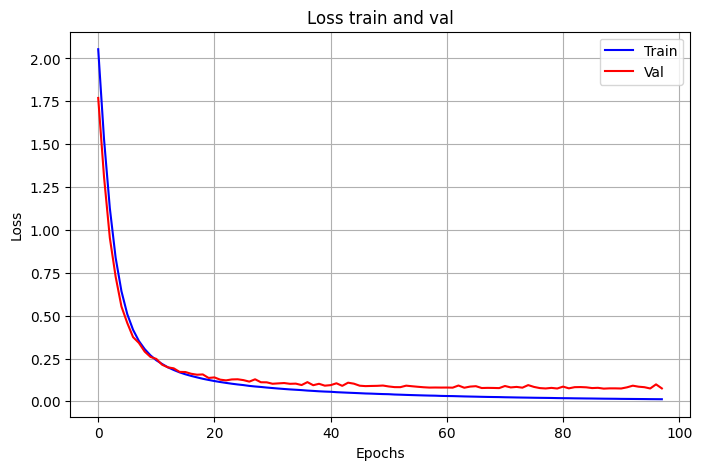

Accuracy:  0.9754789272030652
confusion:  [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.99193548 0.         0.         0.         0.
  0.         0.         0.00806452 0.        ]
 [0.         0.00694444 0.97222222 0.         0.01388889 0.00694444
  0.         0.         0.         0.        ]
 [0.         0.         0.00763359 0.99236641 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00769231 0.         0.         0.96153846 0.
  0.         0.         0.00769231 0.02307692]
 [0.         0.         0.         0.0075188  0.         0.94736842
  0.         0.         0.         0.04511278]
 [0.         0.         0.         0.         0.00793651 0.
  0.99206349 0.         0.         0.        ]
 [0.         0.         0.         0.         0.00694444 0.
  0.         0.98611111 0.         0.00694444]
 [0.00854701 0.03418803 0.         0.         0.00854701 0.00854701
  0.         0.   

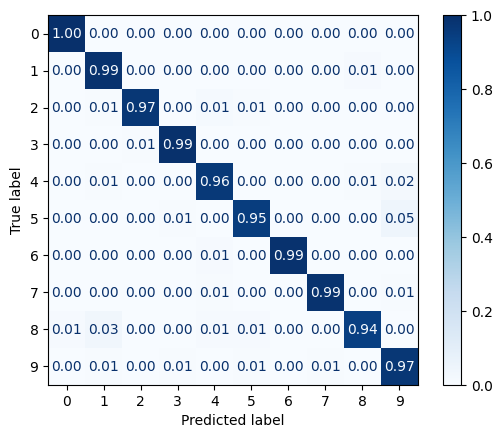

In [40]:
model4 = nn.Sequential(
    nn.Linear(64, 40),
    nn.Tanh(),
    nn.Linear(40, 10)
)
dataloader_train4 = create_dataloader(df_train, batch_size)
dataloader_val4 = create_dataloader(df_val, batch_size)
loss_train4, loss_val4, epochs4 = train_and_evaluate(model4, dataloader_train4, dataloader_val4, patience, max_epochs)
plot_loss(epochs4, loss_train4, loss_val4)
evaluate_model(model4, dataloader_val4)

# **(e) 2 capas ocultas con 10 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2868, val loss: 2.2566
Epoch: 1, train loss: 2.2194, val loss: 2.1691
Epoch: 2, train loss: 2.0996, val loss: 1.9990
Epoch: 3, train loss: 1.9116, val loss: 1.7752
Epoch: 4, train loss: 1.6639, val loss: 1.4977
Epoch: 5, train loss: 1.3899, val loss: 1.2161
Epoch: 6, train loss: 1.1380, val loss: 1.0044
Epoch: 7, train loss: 0.9364, val loss: 0.8304
Epoch: 8, train loss: 0.7829, val loss: 0.7203
Epoch: 9, train loss: 0.6698, val loss: 0.6280
Epoch: 10, train loss: 0.5865, val loss: 0.5427
Epoch: 11, train loss: 0.5233, val loss: 0.5145
Epoch: 12, train loss: 0.4724, val loss: 0.4523
Epoch: 13, train loss: 0.4314, val loss: 0.4128
Epoch: 14, train loss: 0.3951, val loss: 0.3973
Epoch: 15, train loss: 0.3667, val loss: 0.3861
Epoch: 16, train loss: 0.3391, val loss: 0.3536
Epoch: 17, train loss: 0.3117, val loss: 0.3428
Epoch: 18, train loss: 0.2876, val loss: 0.3112
Epoch: 19, train loss: 0.2637, val loss: 0.2753
Epoch: 20, train loss: 0.2397, val loss: 0.2619
Ep

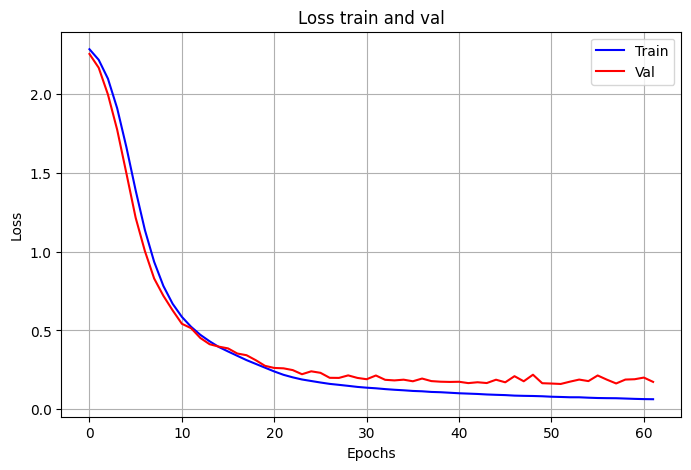

Accuracy:  0.9547892720306513
confusion:  [[0.98425197 0.         0.00787402 0.         0.00787402 0.
  0.         0.         0.         0.        ]
 [0.         0.93548387 0.         0.         0.         0.
  0.00806452 0.00806452 0.04032258 0.00806452]
 [0.         0.00694444 0.97222222 0.         0.00694444 0.
  0.         0.00694444 0.00694444 0.        ]
 [0.         0.         0.00763359 0.96946565 0.         0.
  0.         0.00763359 0.00763359 0.00763359]
 [0.         0.00769231 0.         0.         0.92307692 0.
  0.00769231 0.02307692 0.00769231 0.03076923]
 [0.02255639 0.         0.         0.0075188  0.         0.93984962
  0.         0.         0.         0.03007519]
 [0.00793651 0.         0.         0.         0.         0.00793651
  0.98412698 0.         0.         0.        ]
 [0.         0.00694444 0.         0.         0.00694444 0.
  0.         0.97916667 0.         0.00694444]
 [0.         0.03418803 0.00854701 0.         0.         0.00854701
  0.         0.   

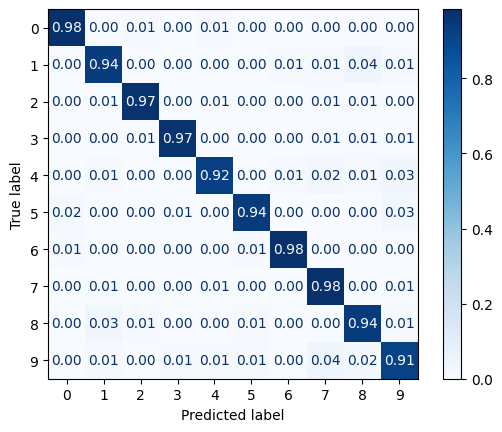

In [41]:
model5 = nn.Sequential(
    nn.Linear(64, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 10)
)
dataloader_train5 = create_dataloader(df_train, batch_size)
dataloader_val5 = create_dataloader(df_val, batch_size)
loss_train5, loss_val5, epochs5 = train_and_evaluate(model5, dataloader_train5, dataloader_val5, patience, max_epochs)
plot_loss(epochs5, loss_train5, loss_val5)
evaluate_model(model5, dataloader_val5)

# **(e) 2 capas de 40 neuronas, ReLU, 1000 épocas**

Epoch: 0, train loss: 2.2143, val loss: 2.0829
Epoch: 1, train loss: 1.8527, val loss: 1.5499
Epoch: 2, train loss: 1.2487, val loss: 0.9580
Epoch: 3, train loss: 0.7431, val loss: 0.5697
Epoch: 4, train loss: 0.4338, val loss: 0.3607
Epoch: 5, train loss: 0.2805, val loss: 0.2393
Epoch: 6, train loss: 0.2112, val loss: 0.1981
Epoch: 7, train loss: 0.1720, val loss: 0.1686
Epoch: 8, train loss: 0.1455, val loss: 0.1605
Epoch: 9, train loss: 0.1265, val loss: 0.1388
Epoch: 10, train loss: 0.1109, val loss: 0.1297
Epoch: 11, train loss: 0.0992, val loss: 0.1230
Epoch: 12, train loss: 0.0894, val loss: 0.1490
Epoch: 13, train loss: 0.0803, val loss: 0.1069
Epoch: 14, train loss: 0.0731, val loss: 0.1170
Epoch: 15, train loss: 0.0669, val loss: 0.0985
Epoch: 16, train loss: 0.0605, val loss: 0.1081
Epoch: 17, train loss: 0.0552, val loss: 0.0998
Epoch: 18, train loss: 0.0511, val loss: 0.1052
Epoch: 19, train loss: 0.0470, val loss: 0.1000
Epoch: 20, train loss: 0.0434, val loss: 0.0905
Ep

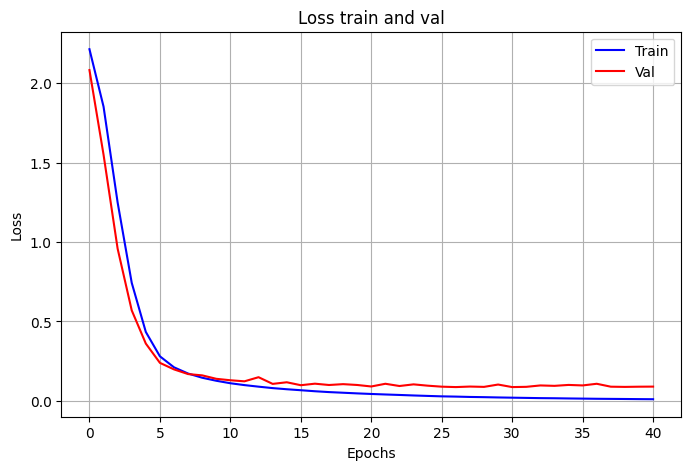

Accuracy:  0.9747126436781609
confusion:  [[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.95967742 0.         0.         0.00806452 0.
  0.         0.         0.03225806 0.        ]
 [0.         0.00694444 0.98611111 0.         0.00694444 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00763359 0.97709924 0.         0.
  0.         0.         0.00763359 0.00763359]
 [0.         0.00769231 0.         0.         0.95384615 0.
  0.00769231 0.         0.00769231 0.02307692]
 [0.         0.         0.         0.0075188  0.         0.96240602
  0.         0.         0.         0.03007519]
 [0.         0.         0.         0.         0.00793651 0.
  0.99206349 0.         0.         0.        ]
 [0.         0.         0.         0.         0.00694444 0.
  0.         0.99305556 0.         0.        ]
 [0.         0.02564103 0.         0.         0.00854701 0.
  0.         0.         0.95726496

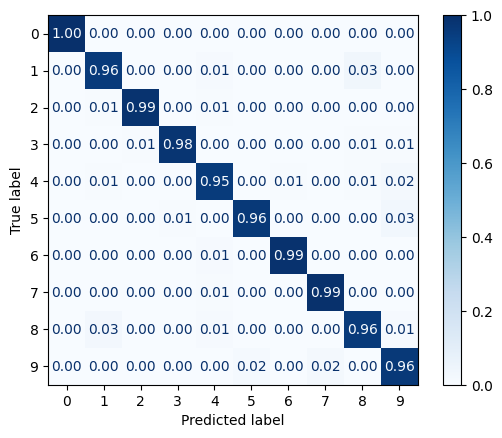

In [42]:
model6 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train6 = create_dataloader(df_train, batch_size)
dataloader_val6 = create_dataloader(df_val, batch_size)
loss_train6, loss_val6, epochs6 = train_and_evaluate(model6, dataloader_train6, dataloader_val6, patience, max_epochs)
plot_loss(epochs6, loss_train6, loss_val6)
evaluate_model(model6, dataloader_val6)

Parte 3) Usando la mejor red en validación, se calcula la matriz de confusión normalizada y el accuracy normalizado, para el conjunto de Prueba

In [45]:
batch_size = 128
patience = 10
max_epochs = 1000

#Función para cargar datos y crear dataloaders
def create_dataloader(df, batch_size=128):
    feats = df.iloc[:, :64].to_numpy().astype(np.float32)
    labels = df.iloc[:, 64].astype(int)
    dataset = [{"features": feats[i, :], "labels": labels.iloc[i]} for i in range(len(feats))]
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return dataloader

#Función para entrenar y evaluar el modelo
def train_and_evaluate(model, dataloader_train, dataloader_test, patience=10, max_epochs=1000): #Como parámetros recibe el modelo de la red neuronal, los dataloaders de entrenamiento y ahora prueba
#el parámetro patience para evitar el overfitting y el número de épocas
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu
    model = model.to(device) #Movemos el modelo para ejecutarlo en gpu

    criterion = nn.CrossEntropyLoss() #Línea que permite controlar la pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #Línea que permite optimizar el funcionamiento del código

    best_validation_loss = float('inf') #Registra el mejor valor de pérdida de validación
    epochs_without_improvement = 0 #Cuenta las cantidades de épocas sin mejora

    loss_train = [] #Arreglo para guardar la pérdida del entrenamiento
    loss_test = [] #Arreglo para guardar la pérdida de prueba
    epochs = [] #Arreglo que guarda las épocas

    start = time.time() #Comenzamos el contador para saber cuánto demora el entrenamiento

    for epoch in range(max_epochs): #Creamos un ciclo, que se repetirá hasta las 1000 épocas
        loss_train_batches = [] #Arreglo para guardar las pérdidas de entrenamiento
        loss_test_batches = [] #Arreglo para guardar las pérdidas de prueba

        model.train() #Con esta línea, nuestro modelo de red neuronal está en modo entrenamiento

        for i, data in enumerate(dataloader_train, 0): #En este recorremos los datos de entrenamiento,
        #se mueven los datos y etiquetas, se calcula la pérdida, se realiza la retropropagación y se actualizan los pesos del modelo.
            inputs = data["features"].to(device)
            labels = data["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train_batches.append(loss.item())

        loss_train.append(np.mean(loss_train_batches)) #Guardamos los valores de pérdida de entrenamiento de cada época

        model.eval() #Colocamos el modelo en modo evaluación

        with torch.no_grad():
            for i, data in enumerate(dataloader_test, 0): #En este bucle recorremos los datos de validación y se calcula la pérdida de prueba.
                inputs = data["features"].to(device)
                labels = data["labels"].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_test_batches.append(loss.item())

        loss_test.append(np.mean(loss_test_batches)) #Guardamos los valores de pérdida de prueba de cada época
        epochs.append(epoch) #Guardamos las épocas ejecutadas

        print("Epoch: %d, train loss: %.4f, test loss: %.4f" % (epoch, loss_train[epoch], loss_test[epoch])) #Imprimimos el número de cada época, la pérdida de entrenamiento de esa época y la pérdida de
        #prueba de esa época

        #Condicionales creadas con el fin de evitar el overfitting, las condiciones son, si no hay mejora en la pérdida de prueba se deja de ejecutar el código
        if loss_test[epoch] < best_validation_loss: #si es menor la pérdida de prueba a la mejor pérdida de prueba
            best_validation_loss = loss_test[epoch] #se convertirá en la nueva mejor pérdida
            torch.save(model.state_dict(), 'best_model_checkpoint.pth') #guardamos
            epochs_without_improvement = 0 #no hay épocas sin mejora
        else:
            epochs_without_improvement += 1 #sino, agregamos 1

        if epochs_without_improvement >= patience: #cuando las épocas sin mejora superan a 10
            break #termina de ejecutarse el entrenamiento

    end = time.time() #terminamos el tiempo
    print('Finished Training, total time %f seconds' % (end - start)) #imprimimos el tiempo final de ejecución

    return loss_train, loss_test, epochs #retornamos

#Función para visualizar la pérdida
def plot_loss(epochs, loss_train, loss_test): #parámetros a  graficar
    plt.figure(figsize=(8, 5))
    plt.title('Loss train and test') #título del gráfico
    plt.xlabel('Epochs') #título del eje x
    plt.ylabel('Loss') #título del eje y
    plt.plot(epochs, loss_train, 'b', label='Train') #graficamos la curva de pérdida de entrenamiento
    plt.plot(epochs, loss_test, 'r', label='Test') #graficamos la curva de pérdida de prueba
    plt.grid() #agregamos cuadrícula
    plt.legend() #agregamos leyenda para cada curva
    plt.show() #mostramos el gráfico

#Función para calcular y mostrar la matriz de confusión y la precisión normalizada
def evaluate_model(model, dataloader):
    model.eval()
    all_predictions = []
    all_labels = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Preparamos el modelo para moverlo a gpu

    for i, data in enumerate(dataloader, 0): #bucle para calcular las predicciones con sus respectivas etiquetas
        inputs = data["features"].to(device)
        labels = data["labels"].to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions, normalize='true')
    accuracy = accuracy_score(all_labels, all_predictions)

    disp = ConfusionMatrixDisplay(confusion, display_labels=np.unique(all_labels))
    disp = disp.plot(cmap="Blues", values_format='.2f')

    print("Accuracy: ", accuracy)

Epoch: 0, train loss: 2.1586, test loss: 1.9525
Epoch: 1, train loss: 1.7477, test loss: 1.5311
Epoch: 2, train loss: 1.3173, test loss: 1.1171
Epoch: 3, train loss: 0.9345, test loss: 0.7940
Epoch: 4, train loss: 0.6542, test loss: 0.5777
Epoch: 5, train loss: 0.4750, test loss: 0.4460
Epoch: 6, train loss: 0.3662, test loss: 0.3656
Epoch: 7, train loss: 0.2983, test loss: 0.3136
Epoch: 8, train loss: 0.2538, test loss: 0.2770
Epoch: 9, train loss: 0.2212, test loss: 0.2490
Epoch: 10, train loss: 0.1967, test loss: 0.2302
Epoch: 11, train loss: 0.1783, test loss: 0.2136
Epoch: 12, train loss: 0.1620, test loss: 0.1991
Epoch: 13, train loss: 0.1487, test loss: 0.1864
Epoch: 14, train loss: 0.1374, test loss: 0.1763
Epoch: 15, train loss: 0.1281, test loss: 0.1684
Epoch: 16, train loss: 0.1203, test loss: 0.1599
Epoch: 17, train loss: 0.1118, test loss: 0.1525
Epoch: 18, train loss: 0.1047, test loss: 0.1472
Epoch: 19, train loss: 0.0989, test loss: 0.1427
Epoch: 20, train loss: 0.0934,

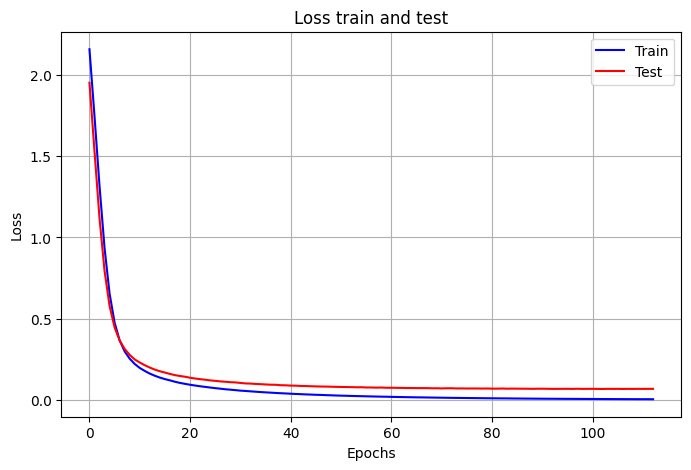

Accuracy:  0.9819182389937107


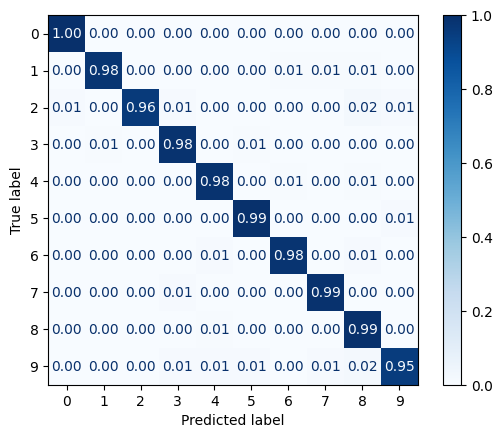

In [46]:
#Modelo 7 correspondiente al modelo 2 del punto (b)
model7 = nn.Sequential(
    nn.Linear(64, 40),
    nn.ReLU(),
    nn.Linear(40, 10)
)
dataloader_train7 = create_dataloader(df_train, batch_size)
dataloader_test7 = create_dataloader(df_test, batch_size)
loss_train7, loss_test7, epochs7 = train_and_evaluate(model7, dataloader_train7, dataloader_test7, patience, max_epochs)
plot_loss(epochs7, loss_train7, loss_test7)
evaluate_model(model7, dataloader_test7)